In [8]:
import MOBSTERm.model_mobster as model_mobster_mv
import numpy as np
import pandas as pd
import pyro.distributions as dist
from scipy import stats

import torch
import seaborn as sns

import matplotlib.pyplot as plt

from MOBSTERm.plot_functions import *
from MOBSTERm.BoundedPareto import BoundedPareto
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
data = pd.read_csv("data/test_data.csv")
data

,mutation_id,chr,from,ref,alt,causes,classes,to,Sample.A.NV,Sample.B.NV,Sample.A.DP,Sample.B.DP,Sample.A.VAF,Sample.B.VAF,chr_pos
0,14_16008308_16008308_T_G,14,16008308,T,G,SBS5,passenger,16008308,5,0,77,87,0.064935,0.000000,16008308
1,14_16021016_16021016_C_A,14,16021016,C,A,SBS5,passenger,16021016,23,0,83,79,0.277108,0.000000,16021016
2,14_16038028_16038028_C_G,14,16038028,C,G,SBS5,passenger,16038028,0,33,79,75,0.000000,0.440000,16038028
3,14_16053575_16053575_G_A,14,16053575,G,A,SBS5,passenger,16053575,0,34,87,75,0.000000,0.453333,16053575
4,14_16072811_16072811_G_A,14,16072811,G,A,SBS1,passenger,16072811,12,0,95,63,0.126316,0.000000,16072811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16587,19_58551962_58551962_G_A,19,58551962,G,A,SBS1,pre-neoplastic,58551962,27,49,62,81,0.435484,0.604938,58551962
16588,19_58557357_58557357_C_T,19,58557357,C,T,SBS5,passenger,58557357,6,0,80,77,0.075000,0.000000,58557357
16589,19_58559817_58559817_A_G,19,58559817,A,G,SBS5,passenger,58559817,0,14,83,69,0.000000,0.202899,58559817
16590,19_58581905_58581905_C_T,19,58581905,C,T,SBS1,passenger,58581905,0,50,74,91,0.000000,0.549451,58581905


In [4]:
sets = ['Sample.A', 'Sample.B']

NV_list = []
DP_list = []

for s in sets:
    print(s)
    NV = torch.tensor(data[f'{s}.NV'].to_numpy())
    DP = torch.tensor(data[f'{s}.DP'].to_numpy())
    
    NV_list.append(NV.view(-1, 1))
    DP_list.append(DP.view(-1, 1))

NV = torch.cat(NV_list, dim=1)
DP = torch.cat(DP_list, dim=1)
purity = [1,1]
print(NV.shape, DP.shape)
K_list = [5,6,7,8,9]

Sample.A
Sample.B
torch.Size([16592, 2]) torch.Size([16592, 2])


In [4]:
seed_list = [40,41]
mb, mb_list = model_mobster_mv.fit(NV, DP, num_iter=1500, K=K_list, seed=seed_list, lr=0.01, purity = purity)

RUN WITH K = 5 AND SEED = 40
Iteration 0: Loss = 1666433163.636021
Iteration 50: Loss = 1365879897.5084097
Iteration 100: Loss = 1324788064.9424753
Iteration 150: Loss = 1314051493.3102503
Iteration 200: Loss = 1310769092.0908785
Iteration 250: Loss = 1309329209.6878967
Iteration 300: Loss = 1308507127.7780154
Iteration 350: Loss = 1308046987.508995
Inference lk:  -78811.91343386358
Final lk:  tensor(-407051.4062, grad_fn=<SumBackward0>)
n_params:  75
n:  tensor(16592)
lk:  tensor(-407051.4062, grad_fn=<SumBackward0>)
bic: 814831.5625 

RUN WITH K = 5 AND SEED = 41
Iteration 0: Loss = 1655982574.789827
Iteration 50: Loss = 1367317855.2895486
Iteration 100: Loss = 1326407100.265678
Iteration 150: Loss = 1315176700.3655803
Iteration 200: Loss = 1311294152.1330252
Iteration 250: Loss = 1309714788.534552
Iteration 300: Loss = 1308924305.4962533
Iteration 350: Loss = 1308395723.986451
Iteration 400: Loss = 1307996725.7397652
Inference lk:  -78817.1979633721
Final lk:  tensor(-407078.3750, g

/Users/elenarivaroli/Dropbox/phd/GitHub/MOBSTERm/MOBSTERm/plot_functions.py:398: UserWarning: The palette list has more values (27) than needed (7), which may not be intended.
  ax = sns.scatterplot(data=df, x=x_col, y=y_col, hue='Cluster', palette=palette, s=20, alpha = 0.7, edgecolor='none') # 'tab20'


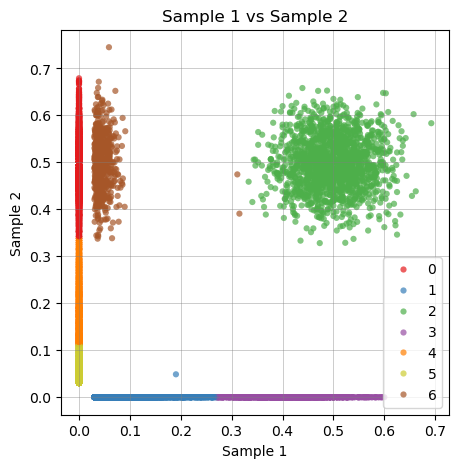

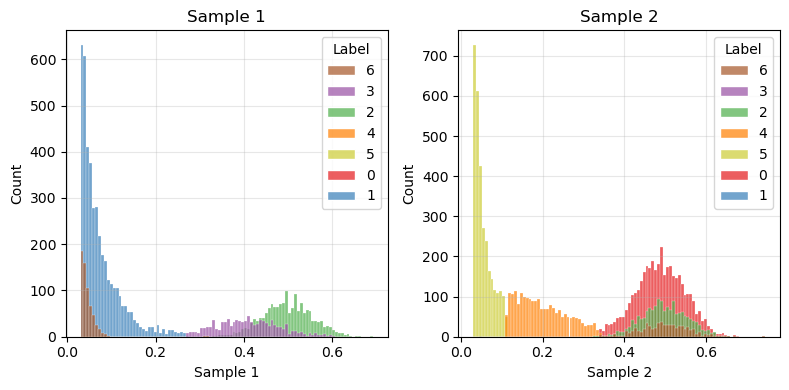

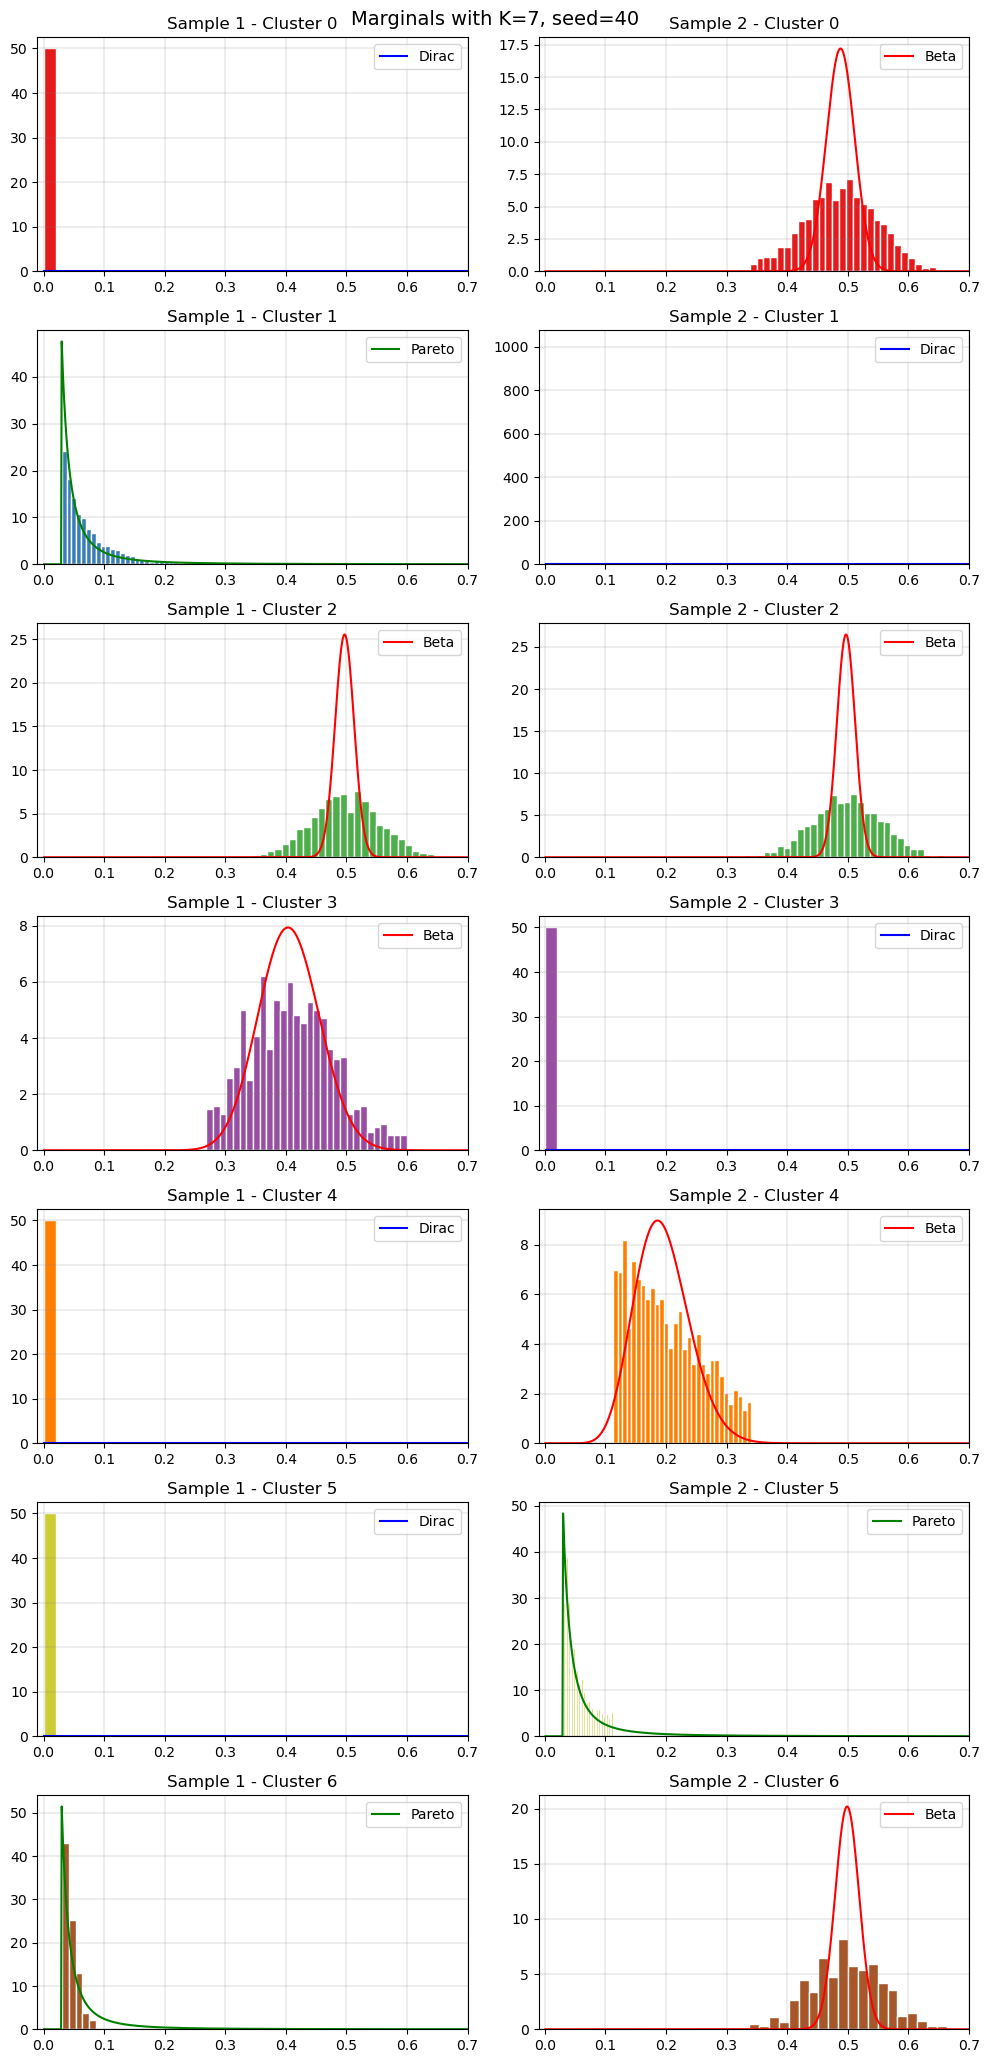

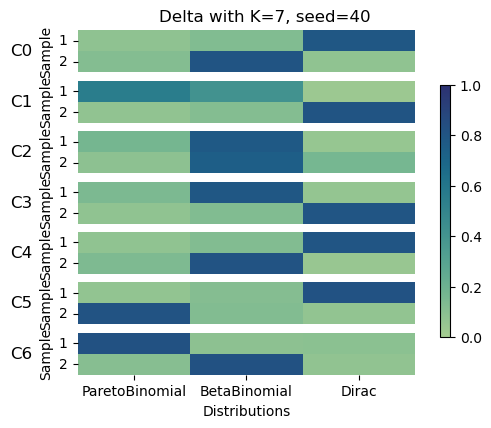

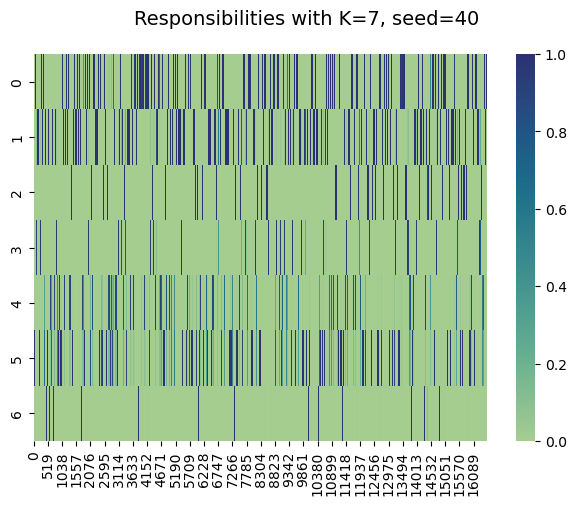

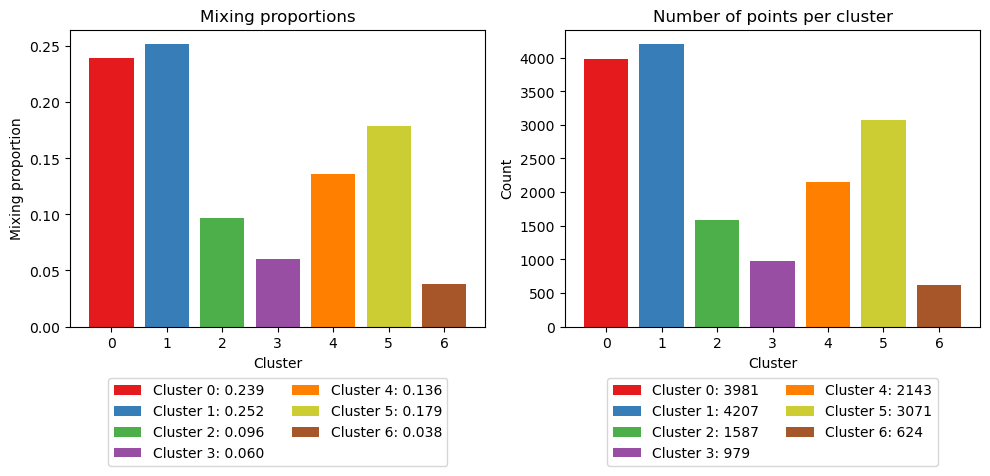

In [ ]:
plot_scatter_inference(mb)
plot_marginals_inference(mb)
plot_marginals_single(mb)
plot_deltas(mb)
#plot_paretos(mb)
#plot_betas(mb)
plot_responsib(mb)
plot_mixing_proportions(mb)

### Test 1D

In [9]:
sets = ['Sample.A', 'Sample.B']

NV_list = []
DP_list = []

for s in sets:
    print(s)
    NV = torch.tensor(data[f'{s}.NV'].to_numpy())
    DP = torch.tensor(data[f'{s}.DP'].to_numpy())
    
    NV_list.append(NV.view(-1, 1))
    DP_list.append(DP.view(-1, 1))

NV = torch.cat(NV_list, dim=1)
DP = torch.cat(DP_list, dim=1)
purity = [1]
print(NV.shape, DP.shape)

Sample.A
Sample.B
torch.Size([16592, 2]) torch.Size([16592, 2])


In [10]:
NV = NV[:,0]
DP = DP[:,0]
idx = np.where(NV!=0)[0]
NV = NV[idx]
DP = DP[idx]

In [11]:
seed_list = [40,41]
K_list = [2,3,4,5]
mb, mb_list = model_mobster_mv.fit(NV, DP, num_iter=1500, K=K_list, seed=seed_list, lr=0.01, purity = purity)

RUN WITH K = 2 AND SEED = 40
Iteration 0: Loss = 199599436.29835686
Iteration 50: Loss = 185903024.04833186
Iteration 100: Loss = 182298749.33281913
Iteration 150: Loss = 181201293.88951838
Iteration 200: Loss = 180823430.55285633
Iteration 250: Loss = 180753217.50232723
Iteration 300: Loss = 180732479.5691263
Iteration 350: Loss = 180717950.3156125
Inference lk:  -24427.413752353586
Final lk:  tensor(-24910.2363, grad_fn=<SumBackward0>)
n_params:  16
n:  tensor(7397)
lk:  tensor(-24910.2363, grad_fn=<SumBackward0>)
bic: 49963.015625 

RUN WITH K = 2 AND SEED = 41
Iteration 0: Loss = 199254796.39057946
Iteration 50: Loss = 185946004.9910971
Iteration 100: Loss = 182583790.0534641
Iteration 150: Loss = 181657146.32449508
Iteration 200: Loss = 181357155.32764083
Iteration 250: Loss = 181236988.72614393
Iteration 300: Loss = 181154026.75921774
Iteration 350: Loss = 181000026.76299635
Inference lk:  -24432.98034724162
Final lk:  tensor(-24918.0273, grad_fn=<SumBackward0>)
n_params:  16
n: 

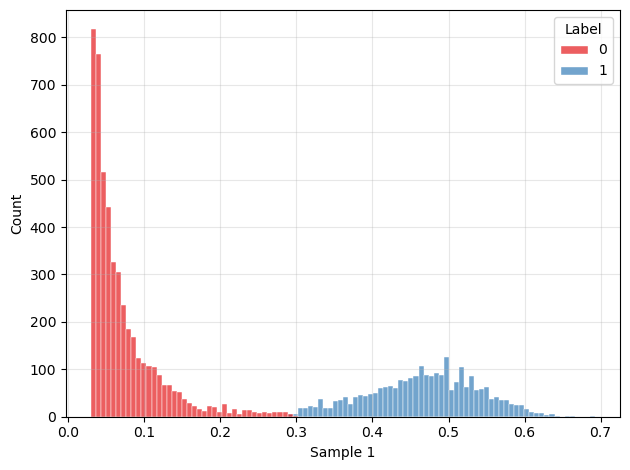

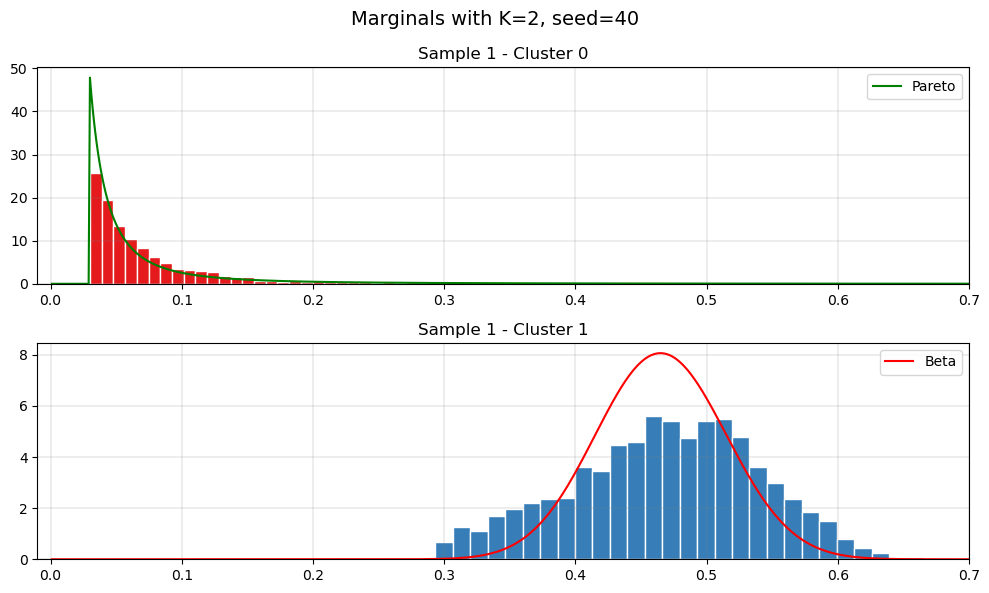

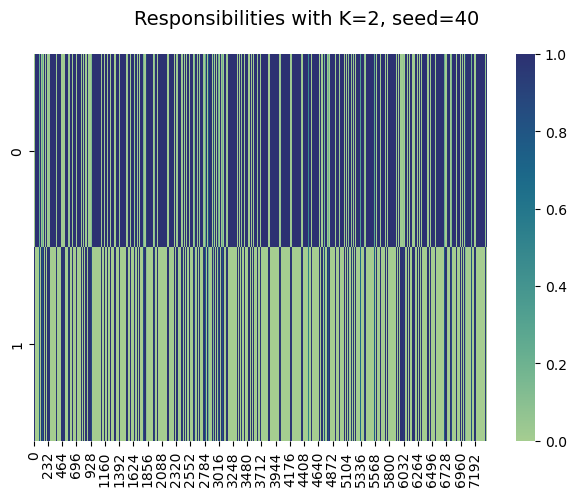

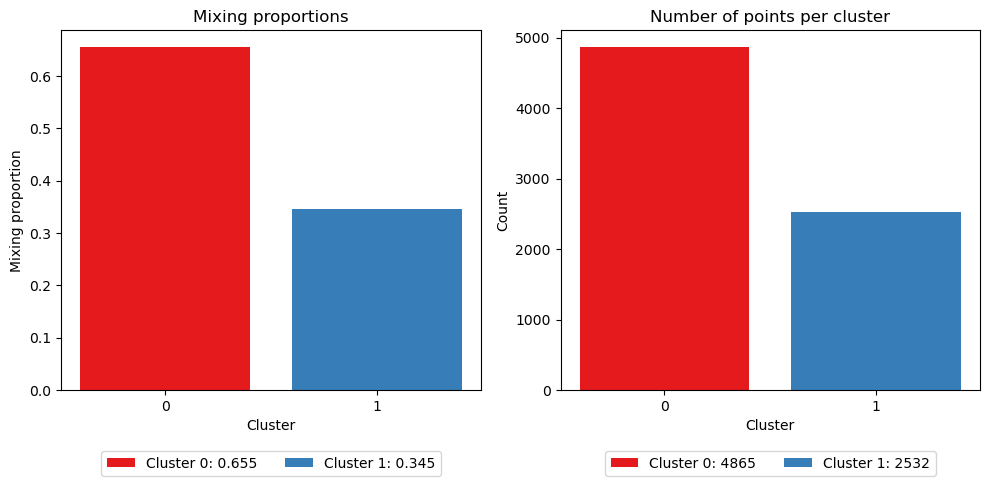

In [12]:
plot_marginals_inference(mb)
plot_marginals_single(mb)
plot_responsib(mb)
plot_mixing_proportions(mb)